In [1]:
from matplotlib.pyplot import figure, rcParams
from conf_matplotlib import conf_matplotlib_oscuro
conf_matplotlib_oscuro()

In [2]:
from datetime import datetime, timedelta

In [3]:
from numpy import pi, degrees, radians, linspace, array

In [4]:
from astropy.coordinates import EarthLocation
from astropy.coordinates import CartesianRepresentation, SphericalRepresentation
from astropy.coordinates import GeocentricTrueEcliptic
from astropy.coordinates import solar_system_ephemeris
from astropy.time import Time, TimeDelta
from astropy import units as u

In [5]:
from poliastro.twobody.propagation import propagate, cowell
from poliastro.twobody.thrust import change_inc_ecc
from poliastro.maneuver import Maneuver
from poliastro.twobody import Orbit
from poliastro.bodies import Earth, Moon, Sun
from poliastro.util import norm
from poliastro.ephem import build_ephem_interpolant

In [6]:
from poliastro.plotting import OrbitPlotter2D, OrbitPlotter3D, StaticOrbitPlotter
from poliastro.core.perturbations import J2_perturbation, third_body
from poliastro.core.util import jit

In [7]:
ΔV = 0.035078249 * u.m/u.s
thruster_secs = 26.88 * u.s
duty_cycle = 0.112 * u.one
thruster_eff = 1 * u.one

duration = thruster_secs / duty_cycle
δv = ΔV/int(duration.value)

thruster_vec = [1,0,0]*δv

EWSK0398 = [Maneuver((duty_cycle*u.s, thruster_vec)) for i in range(int(duration.value))]

In [201]:
third_body?

Signature: third_body(t0, state, k, k_third, third_body)
Docstring:
Calculates 3rd body acceleration (km/s2)

.. math::

    \vec{p} = \mu_{m}\left ( \frac{\vec{r_{m/s}}}{r_{m/s}^3} - \frac{\vec{r_{m}}}{r_{m}^3} \right )

Parameters
----------
t0 : float
    Current time (s)
state : numpy.ndarray
    Six component state vector [x, y, z, vx, vy, vz] (km, km/s).
k : float
    gravitational constant, (km^3/s^2)
third_body: a callable object returning the position of 3rd body
    third body that causes the perturbation

Note
----
This formula is taken from Howard Curtis, section 12.10. As an example, a third body could be
the gravity from the Moon acting on a small satellite.
File:      c:\users\telecomm\anaconda3\lib\site-packages\poliastro\core\perturbations.py
Type:      function


In [8]:
epoch = Time(2000, format='jyear') + TimeDelta(638594520*u.s)
r = [21688591.8, -36154596.3, -22139.6363]*u.m
v = [2636.61379, 1582.13661, -5.16579754]*u.m/u.s

s0 = Orbit.from_vectors(Earth, r=r, v=v, epoch=Time(epoch, format="jyear"))

In [30]:
s0.epoch.jd*u.day

<Quantity 2458936.14027778 d>

In [11]:
s0.classical?

Signature: s0.classical()
Docstring: Classical orbital elements. 
File:      /usr/local/Caskroom/miniconda/base/lib/python3.7/site-packages/poliastro/twobody/orbit.py
Type:      method


In [16]:
s0.classical()

(<Quantity 42163.99697591 km>,
 <Quantity 0.0001488>,
 <Quantity 0.10085322 deg>,
 <Quantity 103.6017778 deg>,
 <Quantity 258.88231762 deg>,
 <Quantity -61.52516827 deg>)

In [22]:
mnvr_epoch = datetime(2020, 3, 27, 16, 37, 5)
ff_time = (mnvr_epoch - epoch.datetime).seconds
downtime = 1 - duty_cycle.value

In [23]:
s1 = s0.propagate(ff_time*u.s, method=cowell, ad=J2_perturbation,
                  J2=Earth.J2.value, R=Earth.R.to(u.km).value)

In [28]:
s1.epoch.jd, s1.classical()

(2458936.1924189813,
 (<Quantity 42163.99710001 km>,
  <Quantity 0.00015857>,
  <Quantity 0.10085224 deg>,
  <Quantity 103.60148648 deg>,
  <Quantity 261.58121884 deg>,
  <Quantity -45.39798601 deg>))

In [147]:
sf = s1

for pulse in EWSK0398:
    sf = sf.apply_maneuver(pulse)
    sf = sf.propagate(downtime*u.s, method=cowell, ad=J2_perturbation,
                      J2=Earth.J2.value, R=Earth.R.to(u.km).value)
    
s1 = s1.propagate((sf.epoch.datetime - s1.epoch.datetime).seconds*u.s, method=cowell,
                  ad=J2_perturbation, J2=Earth.J2.value, R=Earth.R.to(u.km).value)

In [148]:
ts = TimeDelta(linspace(1*u.h, 336*u.h, 336))

In [188]:
s1.epoch.jd*u.day

<Quantity 2458936.19519676 d>

In [194]:
from numba import njit

In [202]:
solar_system_ephemeris.set("de432s")

inicio = (s1.epoch).jd*u.day
final  = (s1.epoch + ts[-1]).jd*u.day
moon_r = build_ephem_interpolant(Moon, 28 * u.day, (inicio, final), rtol=1e-05)
sun_r  = build_ephem_interpolant(Sun, 365 * u.day, (inicio, final), rtol=1e-05)


def perturbaciones(t0, state, k, J2, R, k_third_moon, third_body_moon, k_third_sun, third_body_sun):
    pert1 = J2_perturbation(t0, state, k, J2, R)
    pert2 = third_body(t0, state, k, k_third_moon, third_body_moon)
    pert3 = third_body(t0, state, k, k_third_sun, third_body_sun)
    return pert1 + pert2 + pert3

In [203]:
cart_coord_1 = propagate(s1, ts, method=cowell, ad=perturbaciones, J2=Earth.J2.value,
                         R=Earth.R.to(u.km).value, k_third_moon=Moon.k.to(u.km ** 3 / u.s ** 2).value,
                         third_body_moon=moon_r, k_third_sun=Sun.k.to(u.km ** 3 / u.s ** 2).value,
                         third_body_sun=sun_r)
cart_coord_f = propagate(sf, ts, method=cowell, ad=perturbaciones, J2=Earth.J2.value,
                         R=Earth.R.to(u.km).value, k_third_moon=Moon.k.to(u.km ** 3 / u.s ** 2).value,
                         third_body_moon=moon_r, k_third_sun=Sun.k.to(u.km ** 3 / u.s ** 2).value,
                         third_body_sun=sun_r)

efem_1 = [[coord, s1.epoch + delta] for coord, delta in zip(*[cart_coord_1, ts])]
GCTE_coord_1 = [GeocentricTrueEcliptic(efem[0], obstime=efem[1]) for efem in efem_1]

efem_f = [[coord, sf.epoch + delta] for coord, delta in zip(*[cart_coord_f, ts])]
GCTE_coord_f = [GeocentricTrueEcliptic(efem[0], obstime=efem[1]) for efem in efem_f]

longs_1 = [(coord.lon.value - dt_long((s1.epoch + t).datetime))%-360 for coord, t in zip(*[GCTE_coord_1, ts])]
lats_1  = [coord.lat.value for coord in GCTE_coord_1]

longs_f = [(coord.lon.value  - dt_long((s1.epoch + t).datetime))%-360 for coord, t in zip(*[GCTE_coord_f, ts])]
lats_f  = [coord.lat.value for coord in GCTE_coord_f]

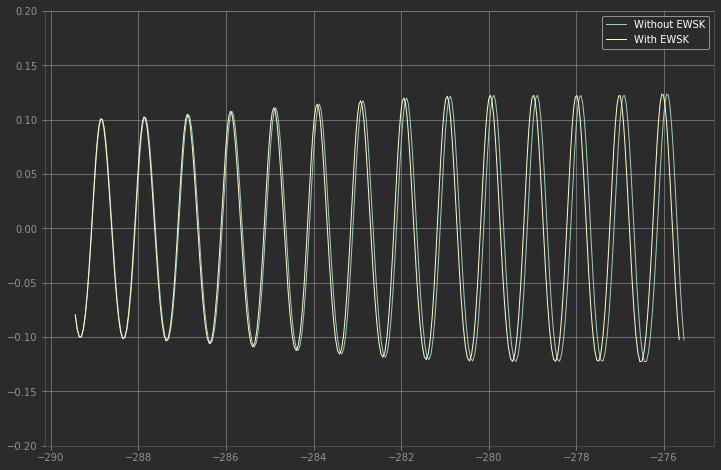

In [204]:
fig = figure(figsize=(12,8))
ax = fig.gca()
ax.plot(longs_1, lats_1, lw=1, label="Without EWSK")
ax.plot(longs_f, lats_f, lw=1, label="With EWSK")
#ax.plot(longs_1[0], lats_1[0], "*", lw=1, label="TF")
#ax.plot(longs_1[-1], lats_1[-1], ".", lw=1, label="TF + 2 Weeks")
ax.set_ylim(-0.2, 0.2)
ax.legend();

In [55]:
coords_1 = []
coords_f = []

for i in range(24*7*2):
    s1 = s1.propagate(3600*u.s, method=cowell, ad=J2_perturbation,
                      J2=Earth.J2.value, R=Earth.R.to(u.km).value)
    coords_1.append([s1.represent_as(SphericalRepresentation), s1.epoch.datetime])
    
    sf = sf.propagate(3600*u.s, method=cowell, ad=J2_perturbation,
                      J2=Earth.J2.value, R=Earth.R.to(u.km).value)
    coords_f.append([sf.represent_as(SphericalRepresentation), sf.epoch.datetime])

In [140]:
def dt_long(time):
    from numpy import pi, degrees
    τ = 2*pi
    hora = time.hour
    minuto = time.minute
    segundo = time.second
    l_hor = τ*hora/24
    l_min = τ*minuto/60/24
    l_seg = τ*segundo/60/60/24
    return degrees(l_hor + l_min + l_seg)

In [57]:
τ = 2*pi
efem_prop_1 = [[coord.lon, coord.lat, time] for coord, time in coords_0]
efem_prop_f = [[coord.lon, coord.lat, time] for coord, time in coords_f]

longs_1, lats_1 = [], []
for lon, lat, tiempo in efem_prop_1:
    longs_1.append(degrees((lon.value - dt_long(tiempo))%-τ))
    lats_1.append(degrees(lat.value))

longs_f, lats_f = [], []
for lon, lat, tiempo in efem_prop_f:
    longs_f.append(degrees((lon.value - dt_long(tiempo))%-τ))
    lats_f.append(degrees(lat.value))

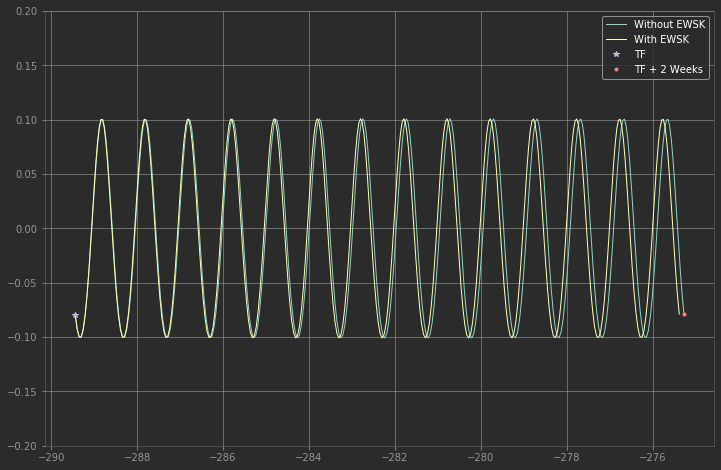

In [65]:
fig = figure(figsize=(12,8))
ax = fig.gca()
ax.plot(longs_1, lats_1, lw=1, label="Without EWSK")
ax.plot(longs_f, lats_f, lw=1, label="With EWSK")
ax.plot(longs_1[0], lats_1[0], "*", lw=1, label="TF")
ax.plot(longs_1[-1], lats_1[-1], ".", lw=1, label="TF + 2 Weeks")
ax.set_ylim(-0.2, 0.2)
ax.legend();